In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from utils.CaImageCSV import CaImageCSV
import utils.sulfur.constant as const

In [43]:
def build_index():
    animal_names = const.ANIMAL_NAMES
    level1 = []
    level2 = []
    for animal_name in const.ANIMAL_NAMES:
        level1.extend([animal_name for _ in const.CONTEXTS])
        level2.extend(const.CONTEXTS)
    return [level1, level2]

In [145]:
columns = ['cell size', 'first', 'excluded']
index = pd.MultiIndex.from_arrays(build_index(), names=('animal name', 'context name'))
spikes = pd.DataFrame(0.0, index=index, columns=columns)
spikes

cell size  first  excluded
animal name  context name                            
ID181106CreA HC1                 0.0    0.0       0.0
             A1preES             0.0    0.0       0.0
             A1postES            0.0    0.0       0.0
             HC2                 0.0    0.0       0.0
             HC3                 0.0    0.0       0.0
...                              ...    ...       ...
ID181106CreQ A4postES            0.0    0.0       0.0
             HC5                 0.0    0.0       0.0
             HC6                 0.0    0.0       0.0
             A5                  0.0    0.0       0.0
             B2                  0.0    0.0       0.0

[170 rows x 3 columns]

In [159]:
def calc_spike_rate(data, cell_size, threshold=0.05):
    return len(data[data > threshold]) / cell_size * 100

for animal_name in const.ANIMAL_NAMES:
    print('animal name: %s' % animal_name)
    
    for context_name in const.CONTEXTS:
        print('context name: %s' % context_name)
        
        csv_file_path = './resources/spikes_data/%s/%s_%s.csv' % (animal_name, animal_name, context_name)
        df = pd.read_csv(csv_file_path, header=[0], index_col=[0, 1], low_memory=False)
        cell_size = len(df.columns)
        spikes.at[(animal_name, context_name), 'cell size'] = cell_size
        
        first_frame = df.iloc[0]
        spikes.at[(animal_name, context_name), 'first'] = calc_spike_rate(first_frame, cell_size)
        
        ave_excluded_spikes = np.array([])
        ave_all_spikes = np.array([])
        excluded_frame = df.iloc[1:]
        for _, row in excluded_frame.iterrows():
            value = calc_spike_rate(row, cell_size)
            ave_excluded_spikes = np.append(ave_excluded_spikes, value)
        spikes.at[(animal_name, context_name), 'excluded'] = ave_excluded_spikes.mean()
        
spikes

animal name: ID181106CreA
context name: HC1
context name: A1preES
context name: A1postES
context name: HC2
context name: HC3
context name: A2_1
context name: A2_2
context name: A3_1
context name: A3_2
context name: B1
context name: HC4
context name: A4preES
context name: A4postES
context name: HC5
context name: HC6
context name: A5
context name: B2
animal name: ID181106CreB
context name: HC1
context name: A1preES
context name: A1postES
context name: HC2
context name: HC3
context name: A2_1
context name: A2_2
context name: A3_1
context name: A3_2
context name: B1
context name: HC4
context name: A4preES
context name: A4postES
context name: HC5
context name: HC6
context name: A5
context name: B2
animal name: ID181106CreC
context name: HC1
context name: A1preES
context name: A1postES
context name: HC2
context name: HC3
context name: A2_1
context name: A2_2
context name: A3_1
context name: A3_2
context name: B1
context name: HC4
context name: A4preES
context name: A4postES
context name: HC5

cell size      first  excluded
animal name  context name                                
ID181106CreA HC1               767.0   5.736636  5.278936
             A1preES           767.0   7.170795  5.643385
             A1postES          767.0   9.387223  6.484601
             HC2               767.0   7.431551  5.654150
             HC3               767.0   4.302477  4.117306
...                              ...        ...       ...
ID181106CreQ A4postES          676.0  11.242604  6.802305
             HC5               676.0   8.431953  6.163232
             HC6               676.0   5.917160  5.236405
             A5                676.0  10.502959  7.849228
             B2                676.0  13.313609  6.635904

[170 rows x 3 columns]

In [163]:
spikes.describe()

,cell size,first,excluded
count,170.00000,170.000000,170.000000
mean,678.10000,8.881849,6.067622
std,156.35503,3.050228,1.534745
min,423.00000,3.113553,1.982845
25%,546.00000,6.751491,5.082522
50%,721.50000,8.933484,6.205892
75%,784.00000,10.785960,6.974963
max,895.00000,17.763158,11.093470


In [164]:
xlabel = ['first', 'excluded']
def view_spikes_differ(data, aix, title):
    animal_count = data.loc['count', xlabel]
    mean = data.loc['mean', xlabel]
    std = data.loc['std', xlabel]
    
    sem = std / np.sqrt(animal_count)
    
    aix.scatter(xlabel, mean, s=200, marker='s')
    aix.errorbar(xlabel, mean, yerr=sem, capsize=20)
    aix.set_ylim((pow(10, -1), pow(10, 2)))
    aix.set_xlim(-0.5, 1.5)
    aix.set_title(title)
    aix.set_yscale('log')

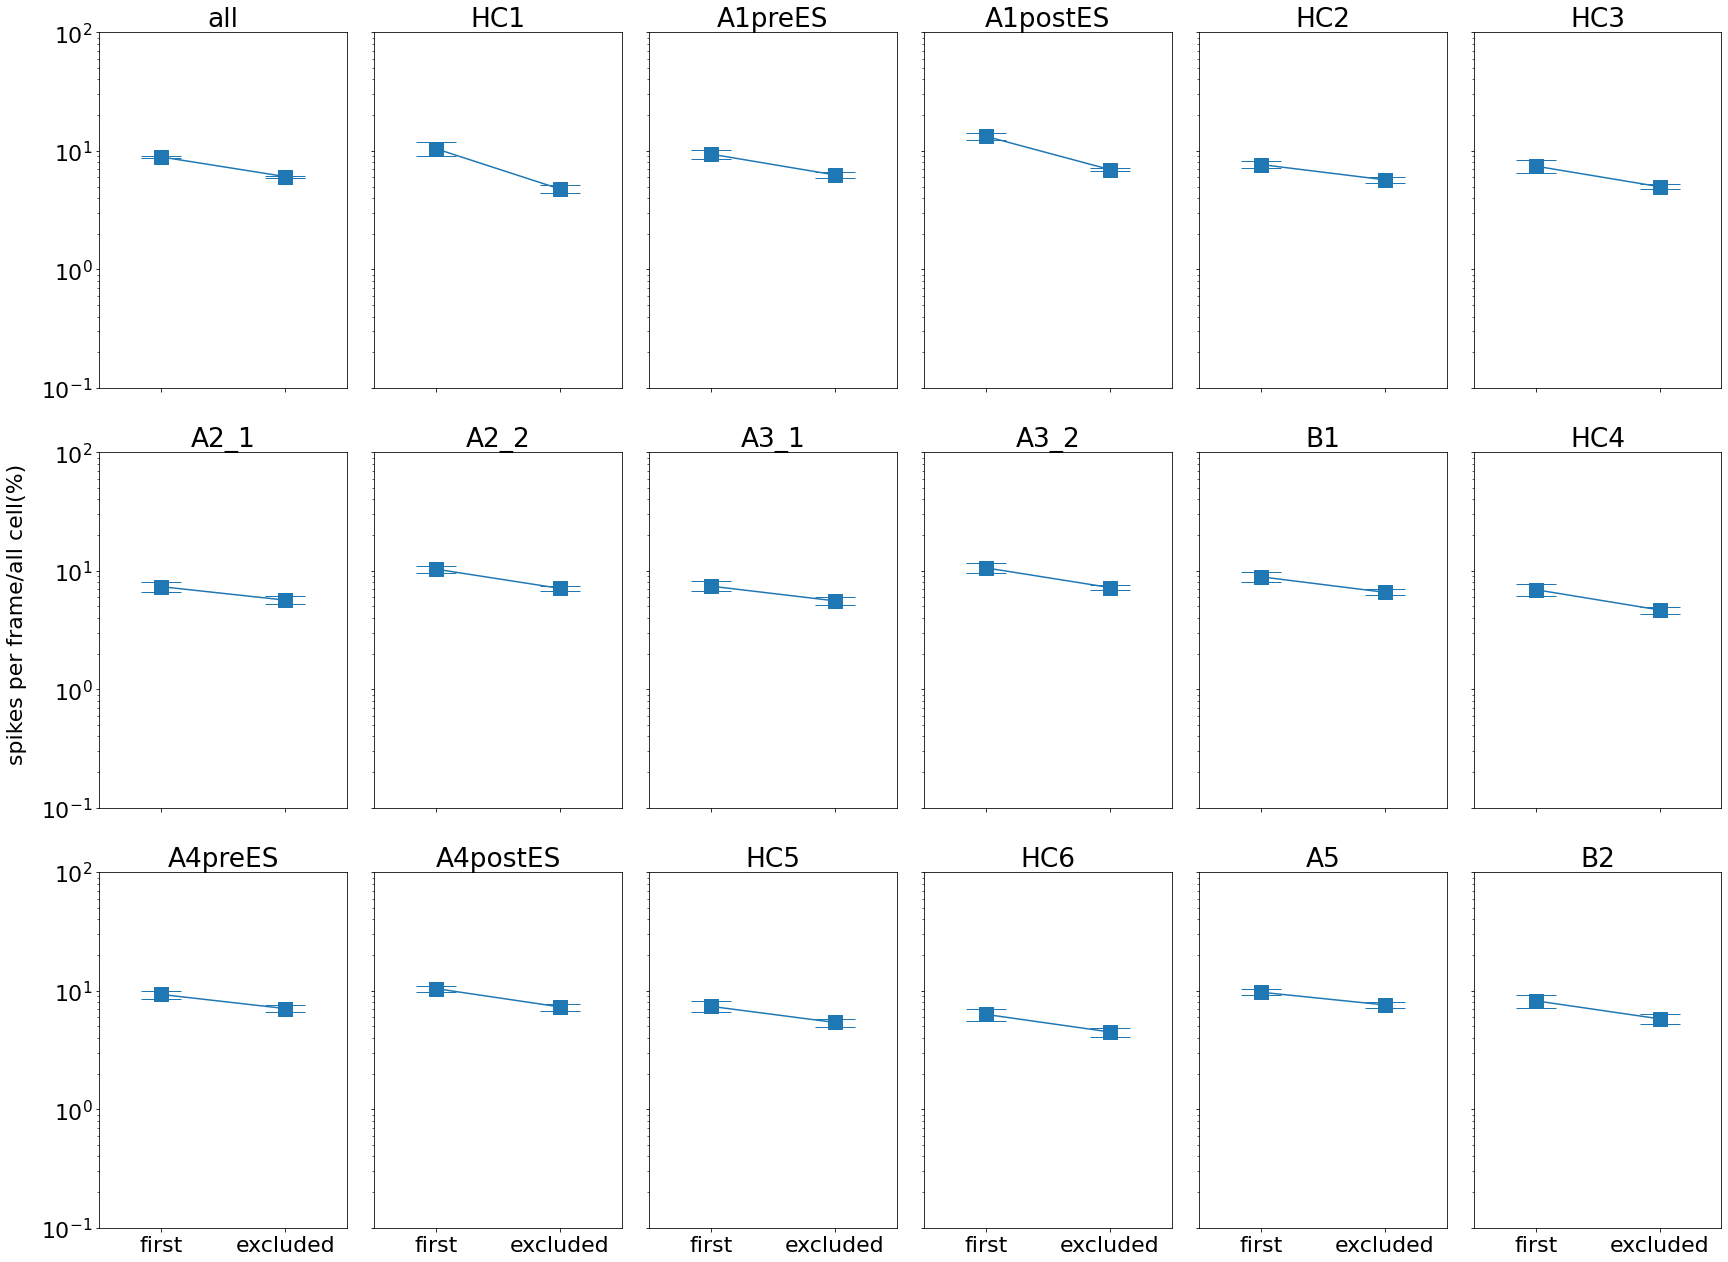

In [167]:
graph_column_count = 6

plt.rcParams["font.size"] = 22
fig, aixs = plt.subplots(nrows=3, ncols=graph_column_count, figsize=(24, 18), tight_layout=True, sharey=True, sharex=True)

view_spikes_differ(spikes.describe(), aixs[0][0], 'all')

for index, context_name in enumerate(const.CONTEXTS):
    g_row = (index + 1) // graph_column_count
    g_col = (index + 1) % graph_column_count
    
    filters = [(animal_name, context_name) for animal_name in const.ANIMAL_NAMES]
    filtered_data = spikes.iloc[spikes.index.isin(filters)]
    desc = filtered_data.describe()
    
    view_spikes_differ(desc, aixs[g_row][g_col], context_name)
    
fig.text(0, 0.4, 'spikes per frame/all cell(%)', ha='center', rotation='vertical')
# plt.show()
plt.savefig('./resources/evaludated_first_frame/figure_threshold005.png')